In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

In [2]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                 "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
              'font.family': 'sans-serif',
              'font.sans-serif': ['Helvetica'],
             # 'text.latex.unicode': True,
              'text.latex.preamble': [r"\usepackage[T1]{fontenc}",
                                      r"\usepackage{lmodern}",
                                      r"\usepackage{amsmath}",
                                      r"\usepackage{mathptmx}"
                                      ],
              'axes.labelsize': 30,
              'axes.titlesize': 30,
              'ytick.right': 'on',
              'xtick.top': 'on',
              'xtick.labelsize': '25',
              'ytick.labelsize': '25',
              'axes.linewidth': 1.8,
              'xtick.major.width': 1.8,
              'xtick.minor.width': 1.8,
              'xtick.major.size': 14,
              'xtick.minor.size': 7,
              'xtick.major.pad': 10,
              'xtick.minor.pad': 10,
              'ytick.major.width': 1.8,
              'ytick.minor.width': 1.8,
              'ytick.major.size': 14,
              'ytick.minor.size': 7,
              'ytick.major.pad': 10,
              'ytick.minor.pad': 10,
              'axes.labelpad': 15,
              'axes.titlepad': 15,
              "xtick.direction": "in",
              "ytick.direction": "in",
              'legend.fontsize': 20}
    mpl.rcParams.update(rcparams) 

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = '#3690c0'

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

def custom_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x',length=10,direction='out')
    ax.tick_params(axis='x',which='minor',direction='out')
    ax.tick_params(axis='y',length=10,direction='out')
    ax.tick_params(axis='y',which='minor',direction='out')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import random

from datetime import date

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,balanced_accuracy_score

## load data

In [6]:
df_air = pd.read_pickle('../data/networks/US_air_1990_2018.pkl')
nodes = set(df_air.source.unique())|set(df_air.target.unique())
df_air = df_air[df_air.source != df_air.target]
year = list(df_air.index.get_level_values(0).unique())
month = list(df_air.index.get_level_values(1).unique())
graphs_air = []
date_air = []
for y in year:
    for m in month:
#        if y != 2018 or m != 12:
        df = df_air.loc[y,m]
        date_air.append(date(y,m,1))
        G = nx.from_pandas_edgelist(df_air.loc[y,m], edge_attr=True)
        G.add_nodes_from(nodes)
        graphs_air.append(G)
        

n = date_air.index(date(2004,1,1))
graphs_air = graphs_air[n:]
date_air =  date_air[n:]

del df_air

In [7]:
def match_datasets(data):
    allcities=pd.read_csv("../data/buses_list_of_cities.csv",index_col=0,names=["CityUF"],encoding="utf-8")
    allcities.head()    
    allcities["CityUF"]=allcities["CityUF"].str.upper()
    allcities["CityUF"]=allcities["CityUF"].str.strip()
    allcities["CityUF"]=allcities["CityUF"].str.replace(" , ",", ")
    allcities["CityUF"]=allcities["CityUF"].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    setallcities=set(list(allcities.CityUF.astype(str)))    
    data=data[data['ORIGEM'].isin(list(setallcities))]
    data=data[data['DESTINO'].isin(list(setallcities))]    
    return data

def bus_network(year=2010,month=12):
    data=pd.read_csv("../data/cleaned_buses_data/{}.csv".format(year),index_col=None)
    if month is not False:
        data=data[data.MES==month]
    data=data[data.NUMEROLUGAROFERTADOIDA>0]
    data=match_datasets(data)
    data=data[["ORIGEM","DESTINO"]]
    data=data.groupby(data.columns.tolist()).size().reset_index().rename(columns={0:'weight'})
    data=data.rename(columns={'ORIGEM':'source','DESTINO':'target','NUMEROLUGAROFERTADOIDA':'weight'})
    return data

df_bus = pd.read_pickle('../data/networks/bus_2005_2014.pkl')
df_bus = df_bus[df_bus.source != df_bus.target]
year = list(df_bus.index.get_level_values(0).unique())
month = list(df_bus.index.get_level_values(1).unique())
graphs_bus = []
date_bus = []
for y in year:
    for m in month:
#        if y != 2018 or m != 12:
        df = bus_network(y,m)
        date_bus.append(date(y,m,1))
        G = nx.from_pandas_edgelist(df, edge_attr=True)
        graphs_bus.append(G)
del df_bus

In [8]:
df_air = pd.read_pickle('../results/us_air_data_binary_adding.pkl')

In [9]:
df_air = df_air[df_air.Year>=date(2004,1,1)]

In [10]:
data = pd.read_pickle('../results/brazil_bus_data_binary_adding.pkl')
data = data[data.Year>=date(2004,1,1)]
rename_dict = {}
for column in data.columns:
    if '_index' in column:
        column_v = column.replace('_index','',1)
    else:
        column_v =  column
    rename_dict[column]=column_v.replace('_',' ',3).title()
    
rename_again = {'Common Neighbor' : 'CN', 'Salton':'SA' , 'Jaccard':'JA', 'Sorensen':'SO', 'Hub Promoted':'HPI',
       'Hub Depressed':'HDI', 'Leicht Holme Newman':'LHNI', 'Preferential Attachment':'PA',
       'Adamic Adar':'AA', 'Resource Allocation':'RA', 'Local Path':'LP'}
    
data = data.rename(columns=rename_dict).rename(columns={'Prederential Attachment':'Preferential Attachment'})

columns=['Common Neighbor', 'Salton', 'Jaccard', 'Sorensen', 'Hub Promoted',
       'Hub Depressed', 'Leicht Holme Newman', 'Preferential Attachment',
       'Adamic Adar', 'Resource Allocation', 'Local Path',
        'Year','Edge','Label']

df_bus =  data[columns]

## split edges into training and testing

In [11]:
def get_edge_slice(data,f_train_e=0.7,seed=30):
    df = data
    edges = list(df.Edge.unique())
    random.seed(seed)
    edge_train = random.sample(edges,int(f_train_e*len(edges)))
    edge_test = [e for e in edges if e not in edge_train]
    df_se = df.loc[df['Edge'].isin(edge_train)].drop(columns = ['Edge'])
    df_de = df.loc[df['Edge'].isin(edge_test)].drop(columns = ['Edge'])
    return(df_se,df_de)

In [12]:
air_se,air_de = get_edge_slice(df_air)
bus_se,bus_de = get_edge_slice(df_bus)

KeyboardInterrupt: 

## adding test

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,balanced_accuracy_score
from xgboost import XGBClassifier
import itertools
import math

In [14]:
def local_path(G,nodelist,epsilon = 0.01):
    A = nx.adjacency_matrix(G,weight=None).todense()
    return(A**2+epsilon*A**3)

def my_devide(a,b):
    if a!=0 and b!=0:
        return a/b
    else:
        return 0
    
def get_vector(G,H,edges):
    X,y = [],[]
    Ki = G.degree()
    nodelist = list(G.nodes())
    LPI = local_path(G,nodelist)
    for e in edges:
        u,v = e
        union_size = len(set(G[u])|set(G[v]))
        x = []
        uv_intersection = list(nx.common_neighbors(G,u,v))
        x.append(len(uv_intersection))
        x.append(my_devide(len(uv_intersection),np.sqrt(Ki[u]*Ki[v])))
        x.append(my_devide(len(uv_intersection),union_size))
        x.append(my_devide(2*len(uv_intersection),(Ki[u]+Ki[v])))
        x.append(my_devide(len(uv_intersection),min(Ki[u],Ki[v])))
        x.append(my_devide(len(uv_intersection),max(Ki[u],Ki[v])))
        x.append(my_devide(len(uv_intersection),(Ki[u]*Ki[v])))
        x.append(Ki[u]*Ki[v])
        if len(uv_intersection) == 0:
            x.append(0)
            x.append(0)
        else:    
            x.append(sum([1/math.log(Ki[z]) for z in uv_intersection]))
            x.append(sum(1/Ki[z] for z in uv_intersection))
        x.append(LPI[nodelist.index(u),nodelist.index(v)])
        y.append(int(H.has_edge(u,v)))
        X.append(x)
    return(X,y)

In [15]:
def get_test(graphs,dates,year_test,N=10000):
    i = dates.index(year_test)
    G  = graphs[i]
    H = graphs[i+1]
    nodes = list(G.nodes())
    edges = random.choices(list(itertools.combinations(nodes,2)),k=N)
    edges = list(set(edges).difference(set(G.edges())))
    X_test,y_test = get_vector(G,H,edges)  
    return(X_test,y_test)

In [16]:
def get_confusion_matrix(df,graphs,dates,year_train=date(2004,1,1),year_test = date(2004,2,1),N=5,N_smaple=10000):
    df = df[df.Year == year_train]
    df_se,df_de  = get_edge_slice(df)
    df_se = df.drop(columns= ['Edge'])
    X_train,y_train = df_se[df_se.Year == year_train].drop(columns=['Year','Label']).values,\
                    df_se[df_se.Year == year_train]['Label'].values
 
    clf = XGBClassifier()
    clf.fit(X_train,y_train)
    
    y_train_shuffled = np.copy(y_train)
    np.random.shuffle(y_train_shuffled)
    null = XGBClassifier()
    null.fit(X_train,y_train_shuffled)
    cms,cms_null = [],[]
    for i in range(N):    
        X_test,y_test = get_test(graphs,dates,year_test,N=N_smaple)
        y_pred = clf.predict(X_test) 
        y_pred_null = null.predict(X_test)
        cm = confusion_matrix(y_test,y_pred,labels = [1,0])
        cm_null = confusion_matrix(y_test,y_pred_null,labels = [1,0])
        if cm.sum(axis=1)[0] != 0:
            cms.append(cm.astype('float') / cm.sum(axis = 1)[:,None])
            cms_null.append(cm_null.astype('float') / cm_null.sum(axis = 1)[:,None])   
    return(np.average(cms,axis=0),np.average(cms_null,axis=0))

def pure_plot_confusion_matrix(cm, ax = None):  
    classes = ['NtoP','NtoN']
    #classes = [0,1]
    sns.heatmap(cm, square = True, annot= True, cbar = False, cmap=plt.cm.Blues,ax = ax,annot_kws={"fontsize":25})
    ax.set_xlim(0,2)
    ax.tick_params( bottom=False, right=False,left=False, labeltop=False, labelbottom=True)   
    ax.set(xticks = np.arange(cm.shape[1])+0.5,
           yticks = np.arange(cm.shape[0])+0.25,
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel = 'True label',
           xlabel = 'Predicted label') 

In [17]:
cms_air,cms_null_air = get_confusion_matrix(df_air,
                                            graphs_air,
                                            date_air,
                                            year_train=date(2004,1,1),
                                            year_test = date(2004,1,1),
                                            N=10,
                                            N_smaple=500000)

In [18]:
warnings.simplefilter(action='ignore')

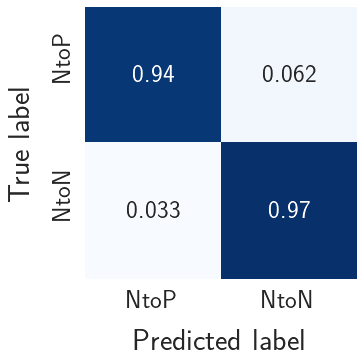

In [19]:
fig,ax = plt.subplots(figsize=(5,5))
pure_plot_confusion_matrix(cms_air,ax=ax)
plt.savefig('../figures/binary_adding_confusion_matrix_structural_air.pdf',transparent=True)
plt.show()

In [20]:
cms_bus,cms_null_bus = get_confusion_matrix(df_bus,
                                            graphs_bus,
                                            date_bus,
                                            year_train=date(2005,1,1),
                                            year_test = date(2005,1,1),
                                            N=10,
                                            N_smaple=1000000)

In [89]:
cms_bus

array([[1.        , 0.        ],
       [0.70061875, 0.29938125]])

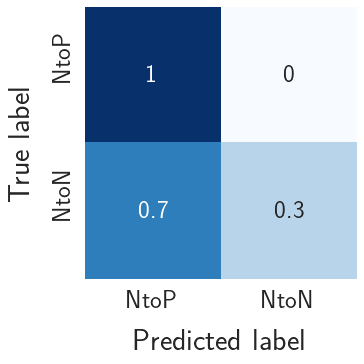

In [21]:
fig,ax = plt.subplots(figsize=(5,5))
pure_plot_confusion_matrix(cms_bus,ax=ax)
plt.savefig('../figures/binary_adding_confusion_matrix_structural_bus.pdf',transparent=True)
plt.show()

## structural test

In [90]:
def structural_test(df,graphs,dates,N=500):
    year_list = list(df.Year.unique())
    accuracies_of_all_network = []
    accuracies_of_all_network_null = []      
    for year in year_list:
        try:
            cms,cms_null = get_confusion_matrix(df,
                                            graphs,
                                            dates,
                                            year_train=year,
                                            year_test = year,
                                            N=10,
                                            N_smaple= 500000)
            accuracies_of_all_network.append(cms)   
            accuracies_of_all_network_null.append(cms_null) 
        except:
            pass
    return(year_list,accuracies_of_all_network,accuracies_of_all_network_null)

In [ ]:
air_years,cms_structural_air,cms_structural_air_null = structural_test(df_air,graphs_air,date_air)

In [ ]:
bus_years,cms_structural_bus,cms_structural_bus_null = structural_test(df_bus,graphs_bus,date_bus)

In [96]:
air_structural = [np.mean([a[0,0],a[1,1]]) for a in cms_structural_air]
air_structural_null = [np.mean([a[0,0],a[1,1]]) for a in cms_structural_air_null]

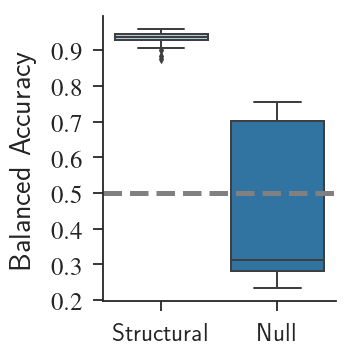

In [101]:
df = pd.concat([pd.DataFrame(dict(Model='Structural',Accuracy=air_structural)),                               
                pd.DataFrame(dict(Model='Null',Accuracy=air_structural_null))])
fig,ax = plt.subplots(figsize=(5,5))
ax = sns.boxplot(x="Model", y="Accuracy",palette='Paired', data=df,ax=ax,linewidth=2)
plt.xticks(rotation=0, ha='center')
custom_frame(ax)
plt.ylabel('Balanced\ Accuracy')
plt.xlabel('')
plt.tight_layout()
ax.axhline(y=0.5, linestyle = '--',color ='grey')
plt.yticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
plt.savefig('../figures/binary_adding_balanced_accuracy_structural_air.pdf',transparent=True)
plt.show()

In [108]:
bus_structural = [np.mean([a[0,0],a[1,1]]) for a in cms_structural_bus if a.shape==(2,2)]
bus_structural_null = [np.mean([a[0,0],a[1,1]]) for a in cms_structural_bus_null if a.shape==(2,2)]

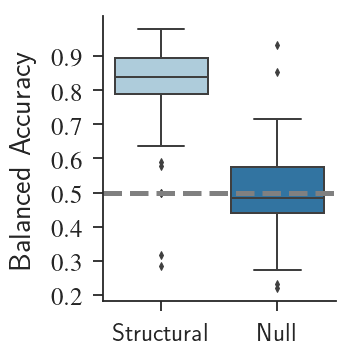

In [109]:
df = pd.concat([pd.DataFrame(dict(Model='Structural',Accuracy=bus_structural)),                               
                pd.DataFrame(dict(Model='Null',Accuracy=bus_structural_null))])
fig,ax = plt.subplots(figsize=(5,5))
ax = sns.boxplot(x="Model", y="Accuracy",palette='Paired', data=df,ax=ax,linewidth=2)
plt.xticks(rotation=0, ha='center')
custom_frame(ax)
plt.ylabel('Balanced\ Accuracy')
plt.xlabel('')
plt.tight_layout()
ax.axhline(y=0.5, linestyle = '--',color ='grey')
plt.yticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
plt.savefig('../figures/binary_adding_balanced_accuracy_structural_bus.pdf',transparent=True)
plt.show()

## general test

In [ ]:
def get_confusion_matrix(df,graphs,dates,year_train=date(2004,1,1),year_test = date(2004,2,1),N=5,N_smaple=10000):
    df = df[df.Year == year_train]
    df_se,df_de  = get_edge_slice(df)
    df_se = df.drop(columns= ['Edge'])
    X_train,y_train = df_se[df_se.Year == year_train].drop(columns=['Year','Label']).values,\
                    df_se[df_se.Year == year_train]['Label'].values
 
    clf = XGBClassifier()
    clf.fit(X_train,y_train)
    
    y_train_shuffled = np.copy(y_train)
    np.random.shuffle(y_train_shuffled)
    null = XGBClassifier()
    null.fit(X_train,y_train_shuffled)
    cms,cms_null = [],[]
    for i in range(N):    
        X_test,y_test = get_test(graphs,dates,year_test,N=N_smaple)
        y_pred = clf.predict(X_test) 
        y_pred_null = null.predict(X_test)
        cm = confusion_matrix(y_test,y_pred,labels = [1,0])
        cm_null = confusion_matrix(y_test,y_pred_null,labels = [1,0])
        cms.append(cm.astype('float') / cm.sum(axis = 1)[:,None])
        cms_null.append(cm_null.astype('float') / cm_null.sum(axis = 1)[:,None])   
    return(np.average(cms,axis=0),np.average(cms_null,axis=0))


def general_test(df,graphs,dates,N=500):
    year_list = list(df.Year.unique())
    accuracies_of_all_network = []
    accuracies_of_all_network_null = []      
    for year in year_list:
        try:
            year_test_list = year_list[year_list.index(year):]
            for year_test in year_test_list:
                cms,cms_null = get_confusion_matrix(df,
                                                graphs,
                                                dates,
                                                year_train=year,
                                                year_test = year_test,
                                                N=2,
                                                N_smaple= 500000)
                accuracies_of_all_network.append(cms)   
                accuracies_of_all_network_null.append(cms_null) 
        except:
            pass
    return(year_list,accuracies_of_all_network,accuracies_of_all_network_null)

In [ ]:
air_years,cms_general_air,cms_general_air_null = general_test(df_air,graphs_air,date_air)

In [ ]:
bus_years,cms_general_bus,cms_general_bus_null = general_test(df_bus,graphs_bus,date_bus)

## save model

In [18]:
import pickle

In [25]:
df = df_air
df = df[df.Year == date(2004,1,1)]
df_se,df_de  = get_edge_slice(df)
df_se = df.drop(columns= ['Edge'])
X_train,y_train = df_se[df_se.Year == date(2004,1,1)].drop(columns=['Year','Label']).values,\
                df_se[df_se.Year == date(2004,1,1)]['Label'].values

clf = XGBClassifier()
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [26]:
pickle.dump(clf, open("../results/binary_adding_model.pickle.dat", "wb"))